In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from keras.utils import get_file
import os

data_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3364/31151/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1681387883&Signature=b%2Fa6hZN1sEaEs4Jhi9Fo1j8HvGjCcXvfw0nuioE7YmaGdCPDQKm4ldyLYh7zg7RtKrHVSABxHa2DJ0qHXbFVpEXszHuExNbkUnelCl7mbEh12g4AH9jMemvZMV61II%2FnxO28t6Y%2B4fK1RprqACBwo4I1SSCeooQ8Qg2qEgNS4OvbYlYnz%2BSJduBXx0UWO8lVL%2BPNJaBRjdSWOD9CQATrf6aelJqlit6Ll1oNGA6ccyMMdXHuw2sc6t8VRR0UySwtpnfVymJmpWi40HDkmoZ4pD86njmmSYcrfquE4pNJFN0M2TywokF2cZw1wxQ64eVWLm1YjlSdn5H2AA2RrNOlAA%3D%3D&response-content-disposition=attachment%3B+filename%3Dchallenges-in-representation-learning-facial-expression-recognition-challenge.zip'

zip_file = get_file(fname = 'challenges-in-representation-learning-facial-expression-recognition-challenge.zip', origin = data_url, extract = True)

base_dir, extension = os.path.splitext(zip_file)

train = pd.read_csv('/root/.keras/datasets/train.csv')

train_df = train[train['emotion'] == 1]
train_df = train_df

df_repeated = pd.concat([train_df]*10, ignore_index=True)

train = pd.concat([train, df_repeated], ignore_index=True, sort=False)

train['pixels'] = [np.fromstring(x, dtype = int, sep = ' ').reshape(-1, 48, 48, 1) for x in train['pixels']]
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, random_state = 101)

X_train_new = np.repeat(X_train, repeats = 3, axis = 3)
X_test_new = np.repeat(X_test, repeats = 3, axis = 3)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(shear_range = 0.2, 
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_iter = train_datagen.flow(X_train_new, y_train)

test_iter = test_datagen.flow(X_test_new, y_test)

train_iter.reset()

batchX, batchy = train_iter.next()

Xmin = batchX.min()
Xmax = batchX.max()

ymin = batchy.min()
ymax = batchy.max()

299063632/299063632 [==============================] - 14s 0us/step


In [ ]:
img_width, img_height = 48, 48
input_shape = (img_width, img_height, 1)

num_class = 7
batch_size = 32
epochs = 100

train_num = 28709
test_num = 7178

train_steps = train_num // batch_size
test_steps = test_num // batch_size

In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape = (48, 48, 3), 
    include_top = False)

base_model.trainable = False

base_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                          

In [ ]:
model = keras.Sequential(name = 'Final_Project_2')
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

Model: "Final_Project_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)             

In [ ]:
from keras.optimizers import Adam

opt = tf.keras.optimizers.Adam()

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train_new, y_train,
           epochs = 100,
           verbose = 1,
           shuffle = True,
           validation_data = (X_test_new, y_test))

Epoch 1/100
827/827 [==============================] - 32s 23ms/step - loss: 2.0426 - accuracy: 0.2522 - val_loss: 1.7355 - val_accuracy: 0.3230
Epoch 2/100
827/827 [==============================] - 15s 18ms/step - loss: 1.7977 - accuracy: 0.2882 - val_loss: 1.6522 - val_accuracy: 0.3660
Epoch 3/100
827/827 [==============================] - 16s 19ms/step - loss: 1.7250 - accuracy: 0.3085 - val_loss: 1.6199 - val_accuracy: 0.3623
Epoch 4/100
827/827 [==============================] - 15s 18ms/step - loss: 1.6765 - accuracy: 0.3281 - val_loss: 1.5605 - val_accuracy: 0.4223
Epoch 5/100
827/827 [==============================] - 15s 18ms/step - loss: 1.6388 - accuracy: 0.3389 - val_loss: 1.5235 - val_accuracy: 0.4308
Epoch 6/100
827/827 [==============================] - 14s 17ms/step - loss: 1.6196 - accuracy: 0.3445 - val_loss: 1.5527 - val_accuracy: 0.4321
Epoch 7/100
827/827 [==============================] - 14s 17ms/step - loss: 1.5941 - accuracy: 0.3547 - val_loss: 1.4795 - val_ac

In [ ]:
score = model.evaluate(test_iter)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train_new).argmax(axis = 1)
y_train = np.argmax(y_train, axis = 1)

confusion_matrix(y_train, y_pred)

207/207 [==============================] - 4s 16ms/step - loss: 2.7843 - accuracy: 0.1187
Test loss: 2.7842581272125244
Test accuracy: 0.11868762969970703
827/827 [==============================] - 10s 11ms/step


array([[2893,  101,    0,   67,  141,    0,   20],
       [ 178, 3658,    0,    0,    0,    0,    0],
       [2306,   54,  133,   60,  708,    2,   28],
       [1050,   31,    1, 4410,  187,    0,   79],
       [1982,   44,    0,   91, 1672,    0,   59],
       [ 948,   51, 1067,  112,   10,  347,    6],
       [1686,   24,    0,  372,  302,    0, 1575]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.90      0.41      3222
           1       0.92      0.95      0.94      3836
           2       0.11      0.04      0.06      3291
           3       0.86      0.77      0.81      5758
           4       0.55      0.43      0.49      3848
           5       0.99      0.14      0.24      2541
           6       0.89      0.40      0.55      3959

    accuracy                           0.56     26455
   macro avg       0.66      0.52      0.50     26455
weighted avg       0.68      0.56      0.55     26455



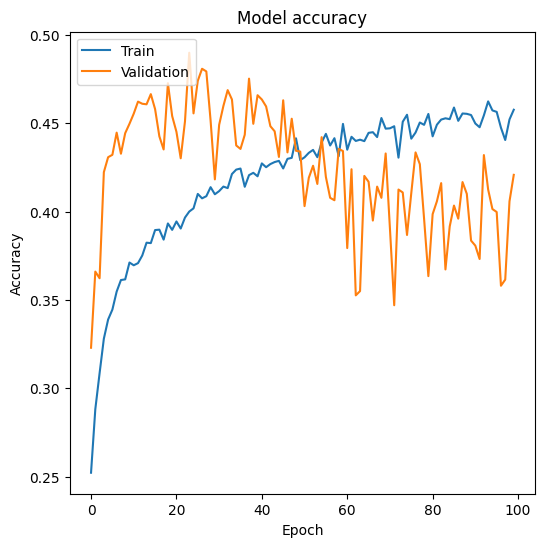

In [ ]:
plt.figure(figsize=(6, 6))
plt.title('Model accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.models.save_model(model, 'resnet.hdf5')